# X-ray challenge

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd ./drive/MyDrive/raw_data


/content/drive/MyDrive/raw_data


In [4]:
%ls


bacterial_pneumonia/  covid-19/  normal/  viral_pneumonia/


In [6]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib.pyplot import imread
import pathlib

In [5]:
print(tf.__version__)

2.4.1


In [6]:
dataset_path = "/content/drive/MyDrive/trainset _balanced"

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256), 
  batch_size=32)

Found 3136 files belonging to 4 classes.
Using 2509 files for training.


In [8]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=32)

Found 3136 files belonging to 4 classes.
Using 627 files for validation.


In [10]:
val_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [11]:
class_names = train_ds.class_names
print(class_names)

['bacterial_pneumonia', 'covid-19', 'normal', 'viral_pneumonia']


In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32,)


In [7]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
#from tensorflow.keras.applications.vgg16 import preprocess_input

#prepos_train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
#image_batch, labels_batch = next(iter(prepos_train_ds))
#first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image)) 


In [14]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 


0.0 0.89901817


In [15]:
normalized_train_ds

<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [16]:
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_val, labels_batch_val = next(iter(normalized_val_ds))
first_image_val = image_batch_val[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image_val), np.max(first_image_val)) 

0.0 0.99987084


In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
from tensorflow.keras import models
from tensorflow.keras import layers 

num_classes = 4

model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
from tensorflow.keras import optimizers

def compile_model(model):
    model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=5, restore_best_weights=True)

In [20]:
model = compile_model(model)

In [21]:
history = model.fit(normalized_train_ds,
         batch_size=32,
         epochs=100, validation_data=normalized_val_ds, callbacks=[es])

Epoch 1/100
79/79 [==============================] - 576s 7s/step - loss: 1.1959 - accuracy: 0.5323 - val_loss: 0.4973 - val_accuracy: 0.8038
Epoch 2/100
79/79 [==============================] - 36s 430ms/step - loss: 0.4047 - accuracy: 0.8447 - val_loss: 0.5389 - val_accuracy: 0.7927
Epoch 3/100
79/79 [==============================] - 36s 431ms/step - loss: 0.3749 - accuracy: 0.8632 - val_loss: 0.4669 - val_accuracy: 0.7959
Epoch 4/100
79/79 [==============================] - 36s 429ms/step - loss: 0.3225 - accuracy: 0.8777 - val_loss: 0.4570 - val_accuracy: 0.8214
Epoch 5/100
79/79 [==============================] - 36s 425ms/step - loss: 0.2478 - accuracy: 0.9096 - val_loss: 0.4387 - val_accuracy: 0.8278
Epoch 6/100
79/79 [==============================] - 36s 427ms/step - loss: 0.2252 - accuracy: 0.9123 - val_loss: 0.4459 - val_accuracy: 0.8325
Epoch 7/100
79/79 [==============================] - 36s 427ms/step - loss: 0.1857 - accuracy: 0.9287 - val_loss: 0.4542 - val_accuracy: 0

In [22]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [24]:
import matplotlib.pyplot as plt

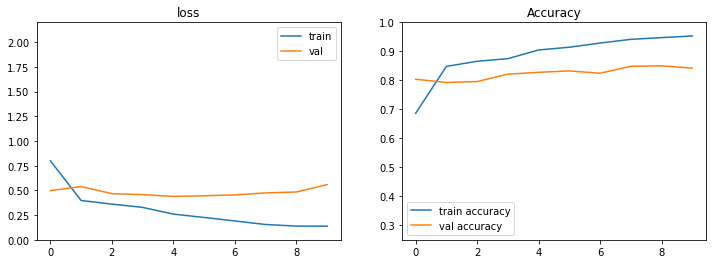

In [25]:
plot_history(history)
plt.show()

In [26]:
from tensorflow.keras import models

# Let's say that you have a `model`
# You can save it :
models.save_model(model, '/content/drive/MyDrive/models/my_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/my_model/assets


In [8]:
from tensorflow.keras import models
loaded_model = models.load_model('/content/drive/MyDrive/models/my_model')

In [9]:
loaded_model

In [10]:
dataset_path_test ="/content/drive/MyDrive/testset_balanced"

In [11]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path_test,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256), 
  batch_size=32)

Found 809 files belonging to 4 classes.
Using 648 files for training.


In [12]:
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_test, labels_batch_test = next(iter(normalized_test_ds))
first_image_test = image_batch_test[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image_test), np.max(first_image_test)) 

0.0 1.0


In [ ]:
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
loaded_model.evaluate(normalized_test_ds, verbose=1)



21/21 [==============================] - 102s 4s/step - loss: 0.5306 - accuracy: 0.8056


[0.5306134819984436, 0.8055555820465088]

In [16]:
labels = []
images = []
for image, label in normalized_test_ds:
  labels += list(np.array(label))
  images += list(np.array(image))

In [17]:
np.array(labels).shape

(648,)

In [18]:
y_true = np.array(labels)

In [19]:
predictions = loaded_model.predict(normalized_test_ds)

In [20]:
y_pred = np.array([np.argmax(x) for x in predictions])

In [21]:
y_true

array([1, 0, 2, 1, 2, 2, 2, 2, 0, 3, 2, 0, 2, 3, 0, 2, 2, 2, 2, 3, 3, 2,
       0, 2, 1, 3, 0, 1, 2, 3, 2, 0, 3, 0, 0, 0, 3, 0, 1, 3, 0, 2, 2, 1,
       0, 2, 3, 1, 3, 2, 3, 1, 2, 1, 1, 2, 0, 1, 3, 1, 3, 1, 0, 0, 2, 3,
       1, 0, 3, 1, 2, 0, 0, 0, 1, 1, 0, 3, 3, 1, 0, 0, 0, 1, 3, 3, 0, 2,
       2, 2, 3, 0, 1, 2, 0, 2, 2, 0, 0, 1, 1, 1, 0, 3, 1, 1, 3, 2, 0, 3,
       3, 3, 1, 1, 3, 0, 3, 0, 3, 3, 2, 3, 3, 1, 2, 3, 1, 1, 1, 0, 0, 0,
       0, 0, 3, 0, 3, 3, 1, 3, 3, 3, 0, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 3,
       2, 1, 0, 0, 0, 0, 0, 2, 3, 1, 1, 1, 1, 3, 1, 2, 0, 1, 1, 3, 1, 0,
       3, 3, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 3, 0, 1, 1, 0, 0, 0, 3, 1,
       1, 1, 3, 1, 1, 1, 2, 2, 0, 0, 3, 0, 0, 3, 3, 3, 0, 3, 0, 0, 2, 3,
       0, 3, 0, 2, 0, 1, 3, 0, 2, 1, 1, 0, 2, 3, 2, 2, 3, 1, 2, 3, 0, 3,
       1, 2, 1, 1, 3, 2, 0, 2, 1, 1, 2, 0, 0, 2, 2, 0, 2, 1, 3, 3, 0, 3,
       2, 1, 2, 1, 2, 2, 3, 0, 1, 0, 2, 0, 2, 3, 0, 1, 3, 3, 1, 3, 2, 3,
       0, 0, 1, 3, 2, 1, 0, 2, 3, 0, 0, 1, 0, 1, 3,

In [22]:
import numpy as np

In [23]:
number_list = y_pred

(unique, counts) = np.unique(number_list, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[  0 188]
 [  1 161]
 [  2 200]
 [  3  99]]


In [24]:
number_list = y_true

(unique, counts) = np.unique(number_list, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[  0 162]
 [  1 162]
 [  2 158]
 [  3 166]]


In [26]:
#class_names # 0, 1, 2, 3

(-0.5, 255.5, 255.5, -0.5)

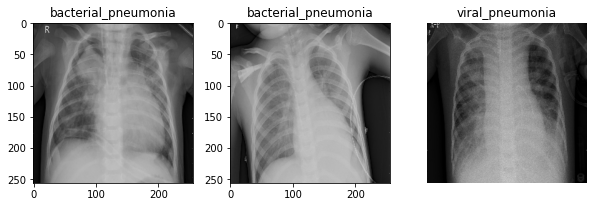

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
plt.axis("off")

In [ ]:
# Y true 1                       #3                       #0
# y pred 1                       #0                       #0
#  'covid-19'.             'bacterial_pneumonia'.     'bacterial_pneumonia'

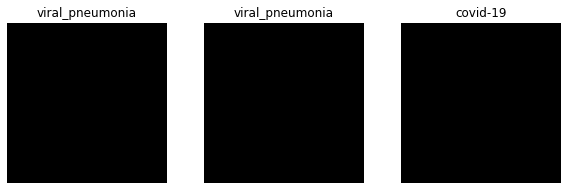

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in normalized_test_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
cm = confusion_matrix(y_true,y_pred)

In [29]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

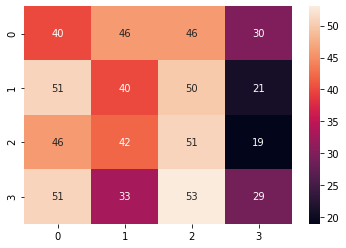

In [30]:
sns.heatmap(cm, annot=True)

In [33]:
 from sklearn.metrics import classification_report

In [34]:
target_names =['bacterial_pneumonia', 'covid-19', 'normal', 'viral_pneumonia']
print(classification_report(y_true, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

bacterial_pneumonia       0.21      0.25      0.23       162
           covid-19       0.25      0.25      0.25       162
             normal       0.26      0.32      0.28       158
    viral_pneumonia       0.29      0.17      0.22       166

           accuracy                           0.25       648
          macro avg       0.25      0.25      0.25       648
       weighted avg       0.25      0.25      0.24       648

